## Ensemble 1: Agregacion de modelos

En este post vamos a discutir una de las ideas mas potentes a la hora de enfrentarse a un problema de Machine learning, ya sea de clasificacion o de regresion, los ensembles.

Hasta bien entrado la decada de los 90 los modelos predictivos que se utilizaban eran modelos individuales, donde la decision para cada problema era encontrar el "learner" mas potente dado un problema planteado.

Con el paper Schapire (1990) se sentaron las bases para lo que se conoce como combinacion de modelos.

El termino tiene muchos sinonimos: Forecast aggregation, model averaging, mixture of experts, wisdom of the crowds o predictive combination, pero la base sobre lo que se asienta es la misma, mezclar modelos para generar una prediccion superior a cualquiera individual realizada por un unico modelo.

### 1 Linear ensembles.

Primero vamos a sentar la notacion para el post:

tenemos, los errores del modelo en cuestion: $error = f(x_i)-\hat{f(x_i)}$ donde $f(x_i)$ es el valor real de la funcion a predecir y $\hat{f(x_i)}$ es la estimacion de un modelo sobre los datos de entrada.

Para combinar dichos modelos asumimos $M$ modelos donde $\hat{y_{i,m}}$ es la predicion del modelo $m$ sobre el dato $x_i$, las predicciones se combinaran en una matriz $(I x M)$ llamada $E$, dicha combinacion lineal de la suma de los errores es igual a $Ew$ donde $w$ es un vector de dimension $(1xM)$ con los pesos asignados a cada modelo, con la restriccion: $\textbf{w}^T\textbf{1}_M=1$ donde $\textbf{1}_M$ es la funcion identidad que toma el valor de 1 cuanto M es verdadero y 0 en otro caso, es decir si el modelo ha sido agregado al ensemble.

Ahora lo que queremos es definir el cuadrado de los errores que en algebra entre vectores se representa por el producto entre dichos vectores y matrices (aparece duplicado).

Utilizando los multiplicadores de lagrange para la restriccion de que la suma acumulada de los pesos sumen 1 tenemos que $\mathcal{L}
(\textbf{w})=\textbf{w}^T\textbf{E}^T\textbf{E}\textbf{w}-\lambda (\textbf{w}^T\textbf{1}_M-1)$ igualando la derivada a 0 para hayar el minimo:
$$\frac{\partial}{\partial \textbf{w}}\mathcal{L}(\textbf{w})=\textbf{E}^T\textbf{E}\textbf{w}-\lambda \textbf{1}_M=0 \quad \Leftrightarrow \quad \textbf{w}=\lambda(\textbf{E}^T\textbf{E})^{-1}\textbf{1}_M,$$

Haciendo la derivada respecto de $\lambda$ tenemos que el optimo de los pesos es: $$\textbf{w}^*=\frac{(\textbf{E}^T\textbf{E})^{-1}\textbf{1}_M}{(\textbf{1}_M^T\textbf{E}^T\textbf{E})^{-1}\textbf{1}_M}$$

El problema aqui es que $\textbf{E}^T\textbf{E}$ es una matriz de covarianza de los errores, si hay correlacion entre los errores, es decir si muchos de los modelos estan haciendo las mismas predicciones, dicha matriz si la correlacion entre ambos modelos es alta el peso que se le dara al modelo de menor error sera mucho mayor que el que se le dara al de mayor error que tendra un peso grande pero negativo, esto puede provocar predicciones espurias que no queremos.

Vale tenemos varios modelos y queremos combinarlos porque creemos que la opinion de muchos cuenta mas que la opinion de uno solo, pero nos ha surgido el problema anteriormente citado, que podemos hacer para evitarlo?.

La respuesta reside en la diversificacion de los modelos utilizados.

### 2 Modelos de agregacion, bootstrap y bagging.

El abordaje de la diversificacion de los modelos con los que contamos empieza con una tecnica estadistica potente pero sencilla.

La tecnica en cuestion se llama bootstrap, la finalidad de este metodo es intentar acercarnos a propiedades de la poblacion (datos totales sobre un fenomeno) con nuestro dataset o sample de la poblacion.

En bootstrap se generan $B$ datasets de un tamano $N$ de nuestros datos, con reemplazamiento, que quiere decir que los  escogidos pueden volver a escogerse en futuros samples.

![bootstrap] (bootstrap.png)

Con estos datasets podemos calcular cantidades que nos fueran de ayuda para hacer hipotesis, intervalos de confianza, medias, medianas, desviaciones etc.

Ahora vamos a presentar el concepto de bagging.

Para que el bootstraping pueda sernos util a la hora de mejorar nuestras predicciones lo que tenemos que hacer es crear $M$ modelos sobre cada uno de los $B$ bootstrap datasets, estos modelos individuales harian una media de sus predicciones (en el caso de un problema de regresion) tal que:

$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^b(x)$$

donde $\hat{f}^b(x)$ es el modelo que ajusta el dataset $b$

Para un problema de clasificacion lo que tenemos que hacer es:

$$\hat{f}_{bag}(x) = \underset{k}{\mathrm{argmax}} \hat{f}^b(x)$$

donde en este caso $\hat{f}^b(x)$ es una K-vector (dimension K)donde K es el numero de clases a predecir y cada indice $p_k(x)$ $\forall k: 1,...,K$ la proporcion de que los clasificadores individuales predigan la clase $k$ en x.

Otra forma de utilizar el bagging para la clasificacion es hacer una media de las probabilidades de que dicho x pertenezca a la clase k.

Para ver la mejora de rendimiento vamos a compararlo con un Decision Tree sobre varios datasets sin preprocesar sus datos.

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn as sk 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_val_score

#modelos 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

random_state = 42

data = load_breast_cancer()

# Datos de ejemplo, Iris dataset, X = variables independientes e y variable dependiente.
X = data.data[:, :]
y = data.target


In [4]:
n_classifiers = {
    'N-DecisionTree' : DecisionTreeClassifier(min_samples_split=2, random_state=random_state),
    'N-Bagging' : BaggingClassifier(base_estimator = DecisionTreeClassifier(),                      random_state=random_state, n_jobs=-1),
    'N-RandomForest' : RandomForestClassifier(random_state=random_state, n_jobs=-1),
}

Para comparar como se comportan dichos modelos en la practica vamos a compararlos sin optimizar sobre el dataset en cuestion y con optimizacion de hiperparametros, en la cual utilizaremos metodos de optimizacion bayesiana para ello.

In [5]:
global_scores = list()
for name_cls, classifier in n_classifiers.items():
    scores = cross_val_score(classifier, X, y, cv=StratifiedKFold(n_splits=10))
    print(f"Accuracy: %0.2f (+/- %0.2f) {scores.mean()}, {scores.std() * 2}")
    global_scores.append(scores)


Accuracy: %0.2f (+/- %0.2f) 0.9281220292109584, 0.06498478052512942
Accuracy: %0.2f (+/- %0.2f) 0.9509009592947887, 0.04354996306003478
/home/blasting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/blasting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/blasting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/blasting/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will ch

In [6]:
list(n_classifiers.keys())

['N-DecisionTree', 'N-Bagging', 'N-RandomForest']

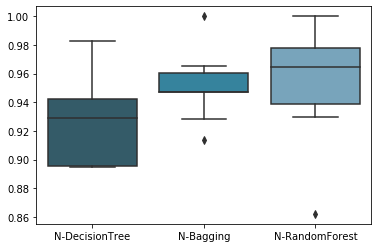

In [7]:
sns.boxplot(x=list(n_classifiers.keys()), y=global_scores, palette='PuBuGn_d')


In [8]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from math import floor
from functools import partial


param_space_rf = {
    'max_depth': hp.choice('max_depth', range(2, 20)),
    'max_features': hp.choice('max_features', range(1,X.shape[1])),
    'n_estimators': hp.choice('n_estimators', range(100,1000)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': hp.choice('min_samples_split', range(2, floor(np.sqrt(X.shape[0]))))
    }


param_space_bagging = {
    'max_features': hp.choice('max_features', range(1,X.shape[1])),
    'n_estimators': hp.choice('n_estimators', range(100,1000)),
}

def f_rf(hps):
    rf = RandomForestClassifier(**hps, random_state=random_state)
    return rf

def f_to_min(hps, X, y, ncv=5):   
    model = f_rf(hps)
 
    cv_res = cross_val_score(model, X, y, cv=StratifiedKFold(ncv, random_state=random_state), 
                             scoring='accuracy', n_jobs=-1)
    
    return {
        'loss': -cv_res.mean(), 
        'cv_std': cv_res.std(), 
        'status': STATUS_OK
    }
    
bagging = BaggingClassifier(random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)

In [89]:
trials = Trials()
best_clf = fmin(partial(f_to_min, X=X, y=y),
                param_space_rf, algo=tpe.suggest, max_evals=1000,
                trials=trials)

28%|██▊       | 284/1000 [24:32<1:31:52,  7.70s/it, best loss: -0.9737591381300501]


KeyboardInterrupt: 

In [22]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize

param_space_rf = [
    Integer(2, 20, name='max_depth'),
    Integer(4, X.shape[1], name='max_features'),
    Integer(100, 1000, name='n_estimators'),
    Categorical(["gini", "entropy"], name='criterion'),
    Integer(2, floor(np.sqrt(X.shape[0])), name='min_samples_split')
]

def f_rf(hps):
    rf = RandomForestClassifier(random_state=random_state)
    return rf


@use_named_args(param_space_rf)
def objective(**params):
    rf = RandomForestClassifier(random_state=random_state)
    rf.set_params(**params)

    return -np.mean(cross_val_score(rf, X, y,
                                    cv=StratifiedKFold(n_splits=5, random_state=random_state),
                                    n_jobs=-1,
                                    scoring="accuracy"))


In [23]:
res_gp = gp_minimize(objective, param_space_rf, n_calls=150, random_state=random_state)

res_gp.fun

/home/blasting/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/blasting/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/blasting/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/blasting/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/blasting/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

-0.9702808772604848

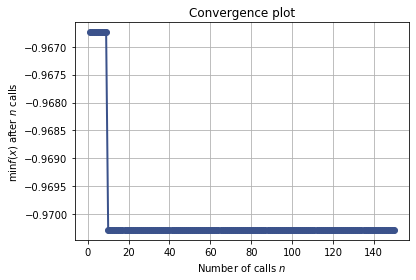

In [28]:
from skopt.plots import plot_convergence, plot_evaluations, plot_objective

plot_convergence(res_gp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fec46896710>,
      dtype=object)

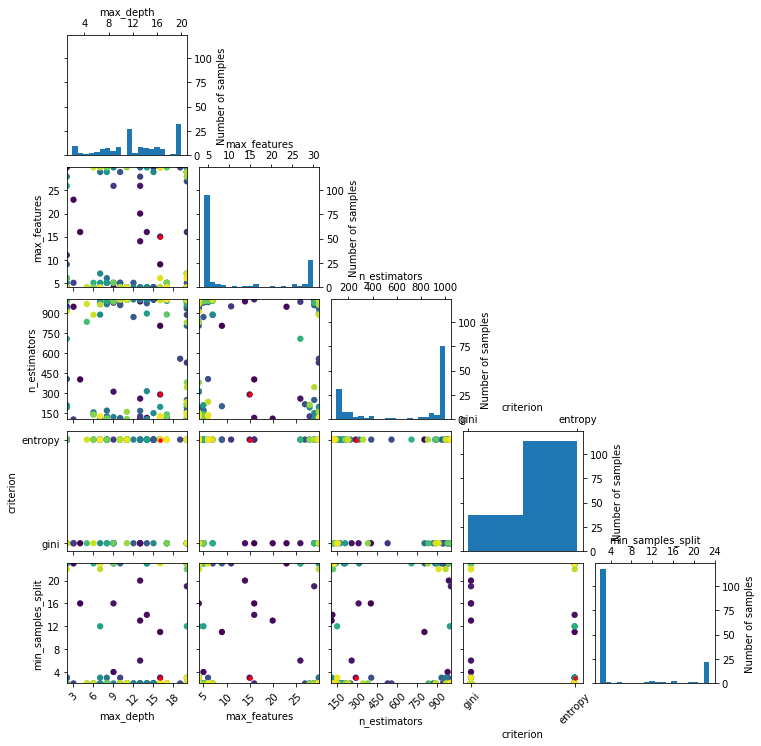

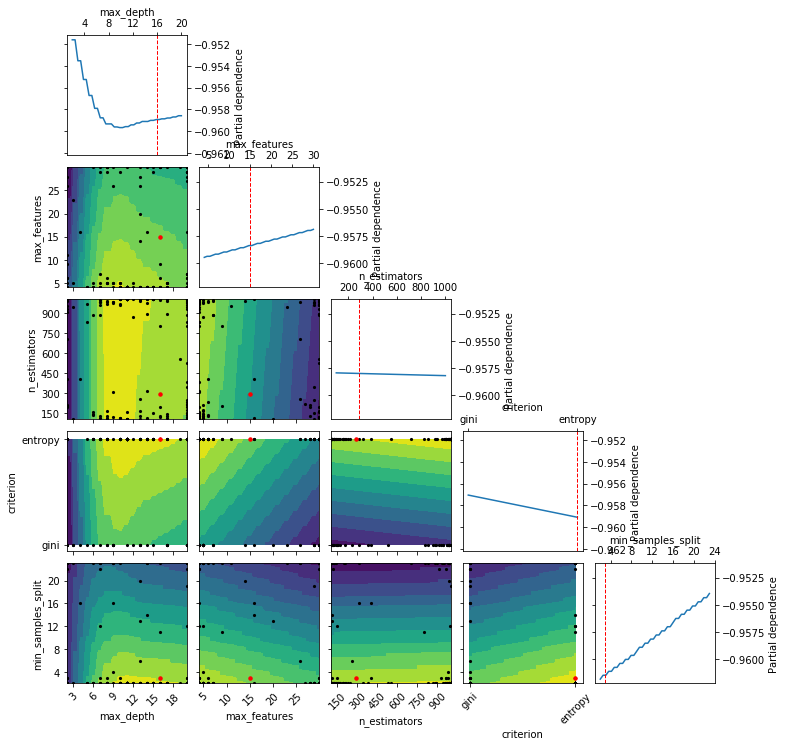

In [29]:
plot_evaluations(res_gp)
plot_objective(res_gp, n_samples=50)

Como podemos ver en la optimizacion que acabamos de realizar, los hyperparametros que aumentan el numero de estimadores en la media bootstrap no tiene que ver en la minimizacion de la funcion objetivo.

Pero por que ocurre esto?.

## La reduccion de la varianza.

Tenemos que queremos encontrar una funcion $\hat{f(x; D)}$ que aproxime la funcion real $y = f(x) + \epsilon $ (donde $\epsilon$ es el ruido existente inherentemente) lo mejor posible, donde $D$ son los datos de entrenamiento tal que $ D = {(x1, y1), ..., (x_n, y_n)} $.

Con estas premisas acotamos una funcion de perdida, en el caso del problema de regression puede ser el error cuadratico medio: $$ (y-\hat{f(x; D)})^2$$ y en el de clasificacion la 'log-loss', que no es mas que una discretizacion de probabilidades de pertenecer a una clase u otra. 

Obviamente, pretendemos que el error sea el menor posible como cuantificacion de como de bueno es nuestro modelo, pero esto no es posible en la practica, ruido inherente en los datos, aproximaciones erroneas, leyes caoticas en fenomenos etc.

### Bias variance tradeof.

Con estas premisas en mente podemos ver que nuestra aproximacion siempre tendra errores, como cuantificamos como de mal lo estamos haciendo a la hora de generalizar? es decir testear el error sobre muestras que el modelo no ha visto nunca?.

Aqui es donde entra en juego el "error esperado" o error de generalizacion, una medida oculta por motivos que ahora veremos y que se puede aproximar mediante tecnicas de aproximacion como cross validation, leave-one-out etc.

El error esperado en el caso de la regresion y el error cuadratico medio es el siguiente:
$$ E_D[(y-\hat{f}(x;D))^2] = (Bias_D[\hat{f}(x;D)])^2 + Var_D[\hat{f}(x;D)] + \epsilon $$
donde 
$$ Bias_D[\hat{f}(x;D)] = E_D[\hat{f}(x;D)] - f(x)$$
y 
$$ Var_D[\hat{f}(x;D)] = E_D[(\hat{f}(x;D)^2- f(x))^2] $$

 Podemos ver el Bias como el error que tiene el modelo sobre sus suposiciones es decir como de bien se adaptan sus suposiciones a la distribucion real de los datos $D$ o funcion real a menor Bias mejor adaptacion, pero, ojo, $D$ son los datos de entrenamiento, a menudo las personas confundimos aprender con memorizar y en el caso de los modelos es lo mismo, podemos acercarnos a un Bias muy bajo memorizando nuestros datos de entrenamiento pero sin embargo nuestra generalizacion sera en la mayoria de los casos pobre.

La varianza por el contrario es una medida de dispersion, en este caso mide como las predicciones de un modelo sobre los potenciales infinitos datasets $D$ varian con respecto a la funcion real, si tenemos una alta varianza tenemos un modelo que hace predicciones erraticas para diferentes datos, las fluctuaciones en los datos de entrenamiento nos alejan de nuestro cometido, por lo tanto una alta varianza nos lleva al overfitting o memorizacion y perdida de generalidad en las predicciones.

Existe una correlacion entre complejidad de modelo y estos dos terminos, por ejemplo una simple regresion lineal (un modelo muy simple parametrico) tiene una un alto Bias y una baja varianza porque no captura la relaccion real entre input y output (high bias) pero sin embargo sus predicciones para diferentes datos son parecidas, no toma como input las posible fluctuaciones sobre los datos.

El tradeof seria encontrar el sweet point entre el Bias y la varianza, un punto donde el error total generalizable sea minimo.

![bias-variance] (bias-variance.jpg)

Este es el transfondo de los metodos ensemble una manera de manejar la complejidad de los modelos utilizando la inteligencia colectiva.

En el caso que nos trae, el bagging es un disminuidor de la varianza.



El bagging como hemos visto anteriormente realmente lo que hace es realizar una media de las predicciones tanto en el caso de la regression como en el caso de la clasificacion donde hace una votacion.

La varianza de un estimador $$Var_D = E_D[(\hat{f}(x;D)^2- f(x))^2] $$
denotado en este caso como $\sigma^2$ tenemos que si utilizamos n_estimadores como modelos simples y estos son i.i.d cada uno con dicha $\sigma^2$ tenemos que la media de las varianzas es: $$\frac{1}{B}\sigma^2$$ entonces tendriamos que cada vez que anadimos un clasificador y sus predicciones son independientes de las de los otros clasificadores del agregado estamos disminuyendo la varianza y si $ B \to \infty$ nos acercamos a la varianza 0 que es lo que queremos.

Lo que se hace con el bagging es utilizar modelos low_bias y high_variance con bastante overfitting por ejemplo arboles de decision sin poda o con pocos ejemplos por split, la mezcla de estos modelos deberia de reducir esa varianza provocada por el overfitting sin afectar al Bias.

En la practica como siempre existe un problema, acabamos de asumir que las predicciones de los modelos son independientes cuando esto claramente no es asi.

Por ello planteamos otra formulacion.

Sea $\rho$ la correlacion entre dos predicciones, ahora tenemos que 

$$ \rho \sigma^2 + \frac{1-\rho}{B}\sigma^2 $$ de esta manera podemos definir bien el limite de cuanto reduciremos la varianza, si existe correlacion entre las predicciones $\rho \to 1$ la varianza se mantiene igual, pero si no existe una correlacion sera reducida en un factor $B$, lo cual sigue siendo interesante. 

Podemos hacerlo mejor?, la respuesta es si, y por bastante, a continuacion os voy a presentar uno de los modelos de Machine learning mas robustos y escalables de todos los que hay para tareas convencionales.

## Random Forest.

La propuesta es sencilla, obligaremos al modelo a generar un ensemble de arboles de decision (en la practica es el modelo mas optimo para la tarea) pero generando los arboles menos correlacionados posibles.

random forest consigue esto haciendo lo siguiente:

Usualmente tenemos un dataset con variables independientes $X$ d-dimensionales es decir cada sample tiene $d$ atributos diferentes, Random forest determina una cantidad $m, m \leq d% de esta manera y con el previo bootstrap tenemos una doble randomizacion, primero con el procedimiento bootstrap obligamos a elegir samples del dataset (filas) y luego elegimos features/atributos (columnas) en cada split del arbol de decision, eligiendo el mejor en cada split, con este metodo generamos $B$ arboles que han sido adaptados a cada bootstrap sample y donde en cada split se eligen de manera aleatoria los features de un subconjunto, en la prediccion a posteriori de un dato se realiza como en bagging, votacion para clasificacion y media para la regresion.

Son todo pros, 
    . Alta paralelizacion pues los arboles se pueden hacer crecer de manera independiente, pues no existen dependencias en los datos.
    . Menor correlacion entre los arboles que generamos debido al sampling

El unico pero que tenemos con Random Forest es que en la practica no podemos mejorar mucho sus resultados con optimizacion de hyperparametros, el numero de estimadores tiene un limite obvio, y los hyperparametros que se permiten cambiar son inherentes al Decision Tree que tienen como base, o al numero de features maximas a samplear, esto lo hace un algoritmo de benchmark base a mejorar en futuras iteraciones y uno de los algoritmos que mas se prueban en etapas tempranas del modelado.

Existen otras variantes como extremely randomized trees, que tiene el mismo procedimiento que Random Forest solo que en cada split nuevo no elegimos la feature que mas discrimine en cuanto a entropia/gini/validacion se refiera, si no que lo elegimos de manera aleatorio, llevando la aleatorizacion a otro extremo; Las consecuencias de este metodo son una mayor Bias a cambio de una nueva posible reduccion de la varianza.

Como todo en esta vida, tenemos una parte buena y una mala.

En el caso de los ensembles la parte mala es sencillamente la perdida de explicabilidad del modelo, perdemos la referencia de modelos tan explicativos como un arbol de decision.

La explicabilidad depende mucho del campo y la aplicacion a desarrollar pero nunca debemos subestimarla, el ciclo de un cientifico de datos o investigador en este tipo de problemas debe de ser ciclica, siempre se puede mejorar el modelo, aunque es cierto que el conocimiento de negocio o campo es de vital importancia, los algoritmos siempre pueden sorprendernos y siempre lo suelen hacer no con una gran precision sobre la variable objetivo, si no mas bien sobre las variables dependientes, casi siempre que miras la importancia de las variables o el analisis previo a todo problema de data science te das cuenta que variables que en un principio pueden parecer inutiles dan una buena cantidad de pistas sobre lo que queremos predecir provocando un gran impacto a la prediccion final o incluso a que variables utilizar y cuales no.

Seguro que no se puede hacer nada con los ensembles en cuestion de explicabilidad?, mentira, pero la metodologia es diferente.